# Metody i algorytmy wyszukiwania ścieżek w grafie w zastosowaniu do przetwarzania obrazów

Celem projektu jest ekstrakcja obiektów liniowych z obrazu i przedstawienie ich w postaci grafu. Obrazem wejściowym może być dowolny obraz zawierający struktury pozwalające przedstawić się za pomocą grafu. Przykładem użytym w tej pracy jest obraz przedstawiający sieć dróg.

Pierwszym krokiem jest zaimportowanie odpowiednich bibliotek, które będą wykorzystywane w dalszej części skryptu:
+ numpy - służy do przedstawiania danych (w tym obrazów) za pomocą tablic wielowymiarowych
+ openCV - biblioteka obsługująca przetwarzenie obrazów
+ matplotlib - pozwala na wyświetlanie obrazów

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Definiowane są funkcje pomocnicze:
+ load_image - ładuje obraz z dysku do pamięci
+ show_image - wyświetla obraz
+ save_image - zapisuje obraz na dysk

In [2]:
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

image_count = 0
def show_and_save_image(image, title, cmap=None):
    global image_count
    filename = '{}-{}.png'.format(image_count, title.replace(' ', '_'))
    cv2.imwrite('results/{}'.format(filename), image)
    image_count = image_count + 1
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()

Po wstępnych przygotowaniach można przejść do właściwego przetwarzania obrazu. Pierwszym krokiem jest załadowanie obrazu źródłowego.

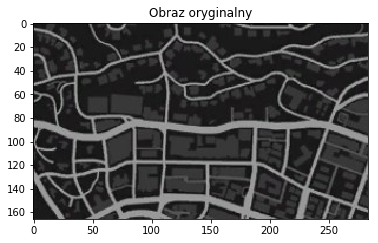

In [3]:
image = load_image('input.jpg')
show_and_save_image(image, 'Obraz oryginalny')

Obraz oryginalny zapisany jest w formacie uwzględniającym kolory, wygodnie jest więc przekonwertować go do skali szarości

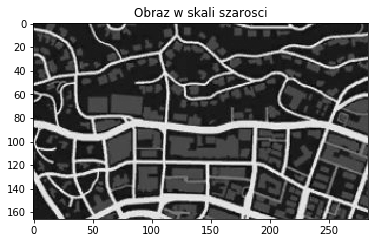

In [4]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_and_save_image(image_gray, 'Obraz w skali szarosci', cmap='gray')

Obraz w skali szarości należy sprogować tak, aby uzyskać tylko widoczne drogi, bez zarysów budynków pomiędzy nimi

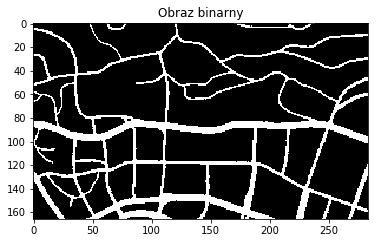

In [5]:
_, image_binary = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
show_and_save_image(image_binary, 'Obraz binarny', cmap='gray')

Dobrze widoczne drogi można poddać procesowi szkieletyzacji, sprowadzając je do postaci linii o szerokości jednego piksela. W tym miejscu warto zauważyć, że wyświetlanie obrazów za pomocą biblioteki matplotlib nie zawsze dokładnie oddaje strukturę prawdziwych danych. W związku z tym otrzymane obrazy zapisuje się też na dysk, aby możliwe było dokładna obserwacja struktury pikseli już poza środowiskiem Jupyter.

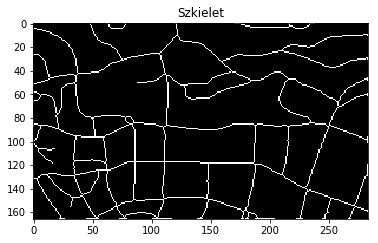

In [6]:
sk = cv2.ximgproc.thinning(image_binary, thinningType = cv2.ximgproc.THINNING_GUOHALL)
show_and_save_image(sk, "Szkielet", cmap='gray')

Proces szkieletyzacji pozostawia po sobie niewielkie artefakty (np. jeden piksel przesunięty w lewo lub w prawo w stosunku do pozostałych pikseli drogi, na której leży), w związku z tym obraz należy oczyścić. Dla rozpatrywanego obrazu wystarczy zastosować procesy dylacji i erozji aby "wygładzić" obraz. Następnie zastosowano znów proces szkieletyzacji aby upewnić się, że droga nadal będzie miała tylko jeden piksel szerokości.

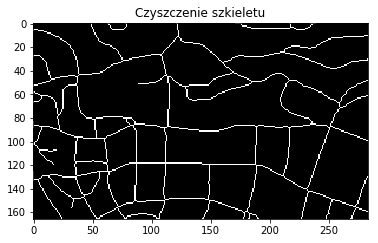

In [7]:
kernel = np.ones((2,2),np.uint8)
dilated = cv2.dilate(sk, kernel)
eroded = cv2.erode(dilated, kernel)
sk2 = cv2.ximgproc.thinning(eroded, thinningType = cv2.ximgproc.THINNING_GUOHALL)
show_and_save_image(sk2, "Czyszczenie szkieletu", cmap='gray')

W tym miejscu kończy się właściwe przetwarzanie obrazu wejściowego. Wynikiem poprzednich działań jest obraz sieci dróg o szerokości jednego piksela, który należy przekonwertować do postaci grafu. Pierwszym krokiem jest znalezienie wszystkich węzłów grafu - w tym przypadku są to skrzyżowania i zakończenia linii. 
Sprawdzenie, czy piksel jest zakończeniem linii jest proste - wystarczy, że ma tylko jednego "aktywnego" sąsiada. Sprawdzenie, czy piksel jest skrzyżowaniem jest bardziej skomplikowane - ilość sąsiadów musi być większa niż 3. Ponadto każdy aktywny piksel sąsiadujący musi mieć co najmniej jeden piksel przerwy od kolejnego aktywnego piksela, na przykład lista sąsiadów `[0, 1, 1, 0, 0, 1, 0, 0]` zawiera tak naprawdę tylko dwóch sąsiadów mimo trzech aktywnych pikseli. W związku z tym badany piksel nie jest skrzyżowaniem.
Do wykonania tego zadania konieczne jest zdefiniowanie kilku funkcji pomocniczych:
+ get_point - zwraca wartość piksela o danych współrzędnych. Jeśli takiego piksela nie ma (tzn. współrzędne wychodzą poza obszar obrazu) zwracana jest wartość 0
+ get_neighbours - zwraca wartości pikseli sąsiadujących z podanym. Zwrócona lista wartości pikseli jest ułożona zgodnie z ruchem wskazówek zegara względem piksela podanego.
+ count_neighbours - oblicza, ile pikseli z podanej listy ma wartość 255.
+ reduce_neighbours - redukuje listę sąsiadów tak, aby zamienić każdą grupę aktywnych pikseli na tylko jednego jej przedstawiciela. Jest to wymagane do poprawnego rozpoznania czy badany piksel jest skrzyżowaniem, co opisano wyżej.
+ is_crossroad i is_tip - sprawdzają, czy dany piksel jest skrzyżowaniem bądź zakończeniem drogi używając do tego funkcji opisanych powyżej.
+ dist - oblicza odległość pomiędzy pikselami

In [8]:
def get_neighbours(image, point):
    neighbours = [
        get_point(image, point[0]-1, point[1]-1),
        get_point(image, point[0]  , point[1]-1),
        get_point(image, point[0]+1, point[1]-1),
        get_point(image, point[0]+1, point[1]  ),
        get_point(image, point[0]+1, point[1]+1),
        get_point(image, point[0]  , point[1]+1),
        get_point(image, point[0]-1, point[1]+1),
        get_point(image, point[0]-1, point[1]  )
    ]
    return neighbours

def get_point(image, x, y):
    try:
        return image[x][y]
    except:
        return 0

def count_neighbours(neighbours):
    return np.sum(neighbours)/255

def reduce_neighbours(neighbours):
    new_neighbours = []
    for i in range(0, len(neighbours)):
        prev = neighbours[i-1]
        current = neighbours[i]
        if prev != current:
            new_neighbours.append(current)
    return new_neighbours

def is_crossroad(image, point):
    if image[point[0]][point[1]] != 255:
        return False
    neighbours = get_neighbours(image, point)
    reduced = reduce_neighbours(neighbours)
    count = count_neighbours(reduced)
    return count >= 3

def is_tip(image, point):
    if image[point[0]][point[1]] != 255:
        return False
    neighbours = get_neighbours(image, point)
    reduced = reduce_neighbours(neighbours)
    count = count_neighbours(reduced)
    return count == 1

import math
def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    

Po przygotowaniu funkcji pomocniczych można bez przeszkód zbadać każdy piksel obrazu pod kątem tego, czy przedstawia on węzel grafu. Znalezione węzły zostają dodane do listy.

In [9]:
shape = sk2.shape
nodes = []
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if is_crossroad(sk2, (i, j)) or is_tip(sk2, (i, j)):
            nodes.append((i, j))

Na przykładowym obrazie zdarzało się, że dwa znalezione węzły leżały bardzo blisko siebie, tak naprawdę reprezentując tylko jedno skrzyżowanie. W związku z tym dla każdej pary punktów sprawdzana jest ich odległość od siebie. Jeśli jest ona zbyt mała - jeden z tych punktów jest usuwany z listy.

In [10]:
filtered_nodes = []
distances = []
rem = []
import itertools
for pair in itertools.combinations(nodes, 2):
    distances.append(dist(pair[0], pair[1]))
    if dist(pair[0], pair[1]) < 2:
        rem.append(pair[1])
filtered_nodes = [node for node in nodes if node not in rem]

Ostatecznie można zaznaczyć wszystkie odnalezione węzły grafu na obrazie - najlepiej obejrzeć zapisany plik .png poza środowiskiem Jupyter.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


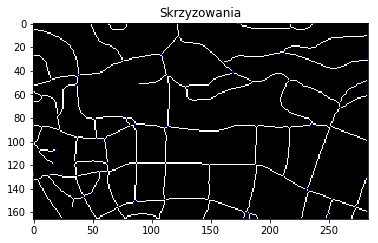

In [11]:
new_img = np.zeros((shape[0], shape[1], 3))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        new_img[i][j] = [sk2[i][j], sk2[i][j], sk2[i][j]]
for node in filtered_nodes:
    new_img[node[0]][node[1]] = [0, 0, 255]
    
show_and_save_image(new_img, "Skrzyzowania")

Po odnalezieniu wszystkich węzłów grafu trzeba jeszcze wyszukać krawędzie. Są one reprezentowane przez drogi, należy jednak wiedzieć, które krawędzie łączą się z którymi węzłami. Do tego celu wykorzystano bibliotekę pathfinding, która oferuje algorytmy wyszukiwania ścieżek. Sposób ich użycia będzie bardzo prosty - dla każdej pary węzłów sprawdzane jest, czy możliwe jest przejście od węzła pierwszego do drugiego po ścieżkach wyznaczonych przez drogi. Jeśli tak - istnieje krawędź łącząca oba węzły.
Aby znaleźć tylko krawędzie łączące węzły bezpośrednio obraz wejściowy dla algorytmu wyszukiwania drogi jest odpowiednio zmodyfikowany - wszystkie punkty, w których znajdują się węzły oraz ich piksele sąsiadujące są wygaszane. Operacja ta przerywa wszystkie drogi tak, że nie jest możliwe przechodzenie pomiędzy nimi. Następnie piksele węzłów badanych są zapalane, aby te konkretne przejścia umożliwić. 

In [12]:
def set_neighbours(image, point, value=255):
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            try:
                image[point[0]+i][point[1]+j] = value
            except:
                pass
    return image

from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
def astar(image, nodes, node1, node2, debug_print=False):
    for node in nodes:
        image = set_neighbours(image, node, 0)
    image = set_neighbours(image, node1, 255)
    image = set_neighbours(image, node2, 255)
    
    grid = Grid(matrix=image)
    start = grid.node(node1[1], node1[0])
    end = grid.node(node2[1], node2[0])
    finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
    path, runs = finder.find_path(start, end, grid)
    if debug_print:
        print('operations:', runs, 'path length:', len(path))
        print(grid.grid_str(path=path, start=start, end=end))
        
    return len(path)

Dla każdej pary węzłów wykonuje się powyższy algorytm. Dla każdej znalezionej dzięki niemu krawędzi zapisuje się węzły, z którymi jest powiązana oraz jej długość otrzymaną od algorytmu wyszukiwania ścieżki.

In [13]:
edges = []
node_range = range(0, len(filtered_nodes))
import itertools
for pair in itertools.combinations(node_range, 2):
    i = pair[0]
    j = pair[1]
    if i == j:
        continue
    path_len = astar(sk2, filtered_nodes, filtered_nodes[i], filtered_nodes[j])
    if path_len == 0:
        continue
    edges.append((i, j, path_len))

Wszystkie wymagane w celach projektu informacje zostały wydobyte z obrazu źródlowego. Można je przedstawić w dowolnej formie, na przykład macierzy sąsiedztwa. Macierz ta dla badanego przypadku będzie duża i rzadka, więc nie musi być to optymalna forma przeglądania informacji o grafie.

In [14]:
neighbour_mtx = np.zeros((len(filtered_nodes), len(filtered_nodes)))
for edge in edges:
    neighbour_mtx[edge[0]][edge[1]] = edge[2]
    neighbour_mtx[edge[1]][edge[0]] = edge[2]
    
for i in range(len(neighbour_mtx)):
    print(neighbour_mtx[i])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 39.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.

Wygodniejsze jest przedstawienie grafu w postaci listy sąsiadów. Dla każdego węzła zdefiniowana została lista jego sąsiadów.

In [15]:
neighbour_list = {i: [] for i in range(len(filtered_nodes))}
for edge in edges:
    neighbour_list[edge[0]].append(edge[1])
    neighbour_list[edge[1]].append(edge[0])
from pprint import pprint
pprint(neighbour_list)

{0: [16],
 1: [2],
 2: [1],
 3: [11],
 4: [8],
 5: [8],
 6: [7, 8],
 7: [6],
 8: [4, 5, 6],
 9: [19],
 10: [12],
 11: [3, 13, 17],
 12: [10, 15, 17],
 13: [11, 16, 20],
 14: [22],
 15: [12],
 16: [0, 13, 19],
 17: [11, 12, 18],
 18: [17, 25, 29],
 19: [9, 16, 21],
 20: [13, 26, 29, 45],
 21: [19, 22, 27],
 22: [14, 21, 28],
 23: [25, 34, 41],
 24: [34],
 25: [18, 23, 29],
 26: [20],
 27: [21, 36, 38],
 28: [22],
 29: [18, 20, 25, 45],
 30: [31],
 31: [30, 33, 36],
 32: [35],
 33: [31],
 34: [23, 24, 35],
 35: [32, 34, 47],
 36: [27, 31, 51],
 37: [38, 40, 43],
 38: [27, 37, 53],
 39: [42],
 40: [37, 43, 49, 61],
 41: [23, 47, 50, 76],
 42: [39, 44, 48],
 43: [37, 40, 54, 61],
 44: [42, 48, 51, 56],
 45: [20, 29, 46, 49],
 46: [45, 50, 65],
 47: [35, 41, 55, 76],
 48: [42, 44],
 49: [40, 45, 62],
 50: [41, 46, 71],
 51: [36, 44, 52],
 52: [51, 53, 59],
 53: [38, 52, 54],
 54: [43, 53, 60],
 55: [47],
 56: [44, 57],
 57: [56, 58, 63],
 58: [57],
 59: [52, 60, 70],
 60: [54, 59, 68],
 61:

Dla zobrazowania działania ekstrakcji grafu przygotowano metodę pozwalającą na zaznaczenie linii łączących wszystkie węzły grafu. Pozwala to na pokazanie topologii grafu z uwzględnieniem faktycznego położenia węzłów na oryginalnym obrazie.

In [16]:
def draw_line(base_image, p1, p2):
    image = base_image.copy()
    return cv2.line(image, tuple(reversed(p1)), tuple(reversed(p2)), color=(255, 0, 0), thickness=2)

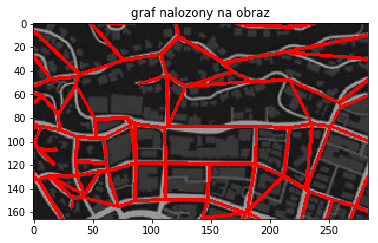

In [17]:
graph_overlayed = image.copy()
for key, value in neighbour_list.items():
    n1 = filtered_nodes[key]
    for n2_idx in value:
        n2 = filtered_nodes[n2_idx]
        graph_overlayed = draw_line(graph_overlayed, n1, n2)
show_and_save_image(graph_overlayed, "graf nalozony na obraz")